In [ ]:
!pip install tensorflow keras numpy matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

# Define paths
base_dir = '/content/drive/MyDrive/FracAtlas'  # Update with your actual path
non_fractured_dir = os.path.join(base_dir, '/content/drive/MyDrive/FracAtlas/images/Non_fractured/non_fracturedaugmented_images')
fractured_dir = os.path.join(base_dir, '/content/drive/MyDrive/FracAtlas/images/Fractured/augmented')  # Assuming this is the fractured images folder

# Create a list of file paths and labels
file_paths = []
labels = []

# Add non-fractured images
for filename in os.listdir(non_fractured_dir):
    file_paths.append(os.path.join(non_fractured_dir, filename))
    labels.append(0)  # 0 for non-fractured

# Add fractured images
for filename in os.listdir(fractured_dir):
    file_paths.append(os.path.join(fractured_dir, filename))
    labels.append(1)  # 1 for fractured

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array

# Prepare training data
train_images = np.array([preprocess_image(path) for path in X_train])
train_labels = np.array(y_train)

# Prepare test data
test_images = np.array([preprocess_image(path) for path in X_test])
test_labels = np.array(y_test)

NameError: name 'np' is not defined

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(128, 128)):
    """
    Load and preprocess an image for the CNN model.

    Args:
        image_path: Path to the image file
        target_size: Tuple specifying the target size (width, height)

    Returns:
        Preprocessed image array
    """
    # Load image and resize
    img = load_img(image_path, target_size=target_size)

    # Convert to numpy array
    img_array = img_to_array(img)

    # Normalize pixel values to [0, 1]
    img_array = img_array / 255.0

    return img_array

# Prepare training data
print("Preprocessing training images...")
train_images = np.array([preprocess_image(path) for path in X_train])
train_labels = np.array(y_train)

# Prepare test data
print("Preprocessing test images...")
test_images = np.array([preprocess_image(path) for path in X_test])
test_labels = np.array(y_test)

print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")

Preprocessing training images...


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7a82b9703d80>

In [ ]:
from PIL import Image
import os

def is_valid_image(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image: {filepath} - {e}")
        return False

# Check all training files
valid_files = [path for path in X_train if is_valid_image(path)]
print(f"Found {len(valid_files)} valid images out of {len(X_train)}")

Invalid image: /content/drive/MyDrive/FracAtlas/images/Non_fractured/non_fracturedaugmented_images/fracture_augmentations_metadata.csv - cannot identify image file '/content/drive/MyDrive/FracAtlas/images/Non_fractured/non_fracturedaugmented_images/fracture_augmentations_metadata.csv'
Found 10494 valid images out of 10495


In [ ]:
from PIL import Image
import os

# Supported image extensions
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}

def is_valid_image(filepath):
    # First check if it's an image file by extension
    if not os.path.splitext(filepath)[1].lower() in IMAGE_EXTENSIONS:
        return False

    # Then verify the image content
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image: {filepath} - {e}")
        return False

# Check all training files
valid_files = [path for path in X_train if is_valid_image(path)]
print(f"Found {len(valid_files)} valid images out of {len(X_train)}")

Found 10494 valid images out of 10495


In [ ]:
# Get indices of valid files
valid_indices = [i for i, path in enumerate(X_train) if is_valid_image(path)]

# Filter X_train and y_train
X_train_filtered = [X_train[i] for i in valid_indices]
y_train_filtered = [y_train[i] for i in valid_indices]

# Do the same for test set if needed
valid_test_indices = [i for i, path in enumerate(X_test) if is_valid_image(path)]
X_test_filtered = [X_test[i] for i in valid_test_indices]
y_test_filtered = [y_test[i] for i in valid_test_indices]

print(f"Filtered training set: {len(X_train_filtered)} images")
print(f"Filtered test set: {len(X_test_filtered)} images")

Filtered training set: 10494 images
Filtered test set: 2624 images


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Target image size
IMG_SIZE = (128, 128)

def preprocess_image(image_path):
    """Load and preprocess a single image"""
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    return img_array / 255.0  # Normalize to [0,1]

# Preprocess all images (this may take a few minutes)
print("Preprocessing training images...")
train_images = np.array([preprocess_image(path) for path in X_train_filtered])
train_labels = np.array(y_train_filtered)

print("Preprocessing test images...")
test_images = np.array([preprocess_image(path) for path in X_test_filtered])
test_labels = np.array(y_test_filtered)

print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")

Preprocessing training images...
Preprocessing test images...
Training data shape: (10494, 128, 128, 3)
Test data shape: (2624, 128, 128, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Classifier
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall')])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,209 (24.86 MB)

 Trainable params: 6,517,249 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=callbacks  # Use the callbacks you defined earlier
)

NameError: name 'callbacks' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

history = model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=callbacks,
    class_weight=class_weights if 'class_weights' in locals() else None
)

Epoch 1/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7659 - loss: 0.5674 - precision: 0.5019 - recall: 0.7064

328/328 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.7661 - loss: 0.5670 - precision: 0.5022 - recall: 0.7063 - val_accuracy: 0.7698 - val_loss: 1.4361 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8925 - loss: 0.2617 - precision: 0.7778 - recall: 0.7299

328/328 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.8925 - loss: 0.2617 - precision: 0.7778 - recall: 0.7299 - val_accuracy: 0.8216 - val_loss: 0.5750 - val_precision: 0.9198 - val_recall: 0.2467 - learning_rate: 0.0010
Epoch 3/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9020 - loss: 0.2455 - precision: 0.8104 - recall: 0.7550

328/328 ━━━━━━━━━━━━━━━━━━━━ 628s 2s/step - accuracy: 0.9020 - loss: 0.2455 - precision: 0.8104 - recall: 0.7550 - val_accuracy: 0.8681 - val_loss: 0.3526 - val_precision: 0.9574 - val_recall: 0.4470 - learning_rate: 0.0010
Epoch 4/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9225 - loss: 0.1927 - precision: 0.8621 - recall: 0.7994

328/328 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.9225 - loss: 0.1927 - precision: 0.8621 - recall: 0.7994 - val_accuracy: 0.9043 - val_loss: 0.2576 - val_precision: 0.9468 - val_recall: 0.6192 - learning_rate: 0.0010
Epoch 5/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9376 - loss: 0.1566 - precision: 0.8918 - recall: 0.8398

328/328 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.9376 - loss: 0.1566 - precision: 0.8918 - recall: 0.8399 - val_accuracy: 0.9116 - val_loss: 0.2385 - val_precision: 0.9604 - val_recall: 0.6424 - learning_rate: 0.0010
Epoch 6/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.9532 - loss: 0.1236 - precision: 0.9099 - recall: 0.8782 - val_accuracy: 0.8175 - val_loss: 0.3798 - val_precision: 0.5609 - val_recall: 0.9536 - learning_rate: 0.0010
Epoch 7/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9575 - loss: 0.1095 - precision: 0.9237 - recall: 0.8935

328/328 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.9575 - loss: 0.1095 - precision: 0.9237 - recall: 0.8935 - val_accuracy: 0.9261 - val_loss: 0.1951 - val_precision: 0.9659 - val_recall: 0.7036 - learning_rate: 0.0010
Epoch 8/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9645 - loss: 0.0958 - precision: 0.9333 - recall: 0.9118

328/328 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.9645 - loss: 0.0958 - precision: 0.9333 - recall: 0.9118 - val_accuracy: 0.9341 - val_loss: 0.1806 - val_precision: 0.9716 - val_recall: 0.7351 - learning_rate: 0.0010
Epoch 9/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 609s 2s/step - accuracy: 0.9607 - loss: 0.0987 - precision: 0.9262 - recall: 0.9016 - val_accuracy: 0.9299 - val_loss: 0.2102 - val_precision: 0.9688 - val_recall: 0.7185 - learning_rate: 0.0010
Epoch 10/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9683 - loss: 0.0821 - precision: 0.9405 - recall: 0.9231

328/328 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.9683 - loss: 0.0821 - precision: 0.9405 - recall: 0.9231 - val_accuracy: 0.9421 - val_loss: 0.1626 - val_precision: 0.9021 - val_recall: 0.8394 - learning_rate: 0.0010
Epoch 11/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9697 - loss: 0.0768 - precision: 0.9431 - recall: 0.9266

328/328 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.9697 - loss: 0.0768 - precision: 0.9431 - recall: 0.9266 - val_accuracy: 0.9455 - val_loss: 0.1608 - val_precision: 0.9619 - val_recall: 0.7947 - learning_rate: 0.0010
Epoch 12/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.9747 - loss: 0.0648 - precision: 0.9579 - recall: 0.9325 - val_accuracy: 0.9383 - val_loss: 0.1918 - val_precision: 0.9682 - val_recall: 0.7566 - learning_rate: 0.0010
Epoch 13/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.9782 - loss: 0.0639 - precision: 0.9587 - recall: 0.9478 - val_accuracy: 0.9337 - val_loss: 0.2248 - val_precision: 0.9574 - val_recall: 0.7450 - learning_rate: 0.0010
Epoch 14/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9812 - loss: 0.0503 - precision: 0.9589 - recall: 0.9590

328/328 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.9812 - loss: 0.0503 - precision: 0.9589 - recall: 0.9590 - val_accuracy: 0.9596 - val_loss: 0.1200 - val_precision: 0.9384 - val_recall: 0.8825 - learning_rate: 0.0010
Epoch 15/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - accuracy: 0.9847 - loss: 0.0429 - precision: 0.9628 - recall: 0.9683 - val_accuracy: 0.9463 - val_loss: 0.1540 - val_precision: 0.9566 - val_recall: 0.8030 - learning_rate: 0.0010
Epoch 16/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.9881 - loss: 0.0360 - precision: 0.9739 - recall: 0.9748 - val_accuracy: 0.9508 - val_loss: 0.1719 - val_precision: 0.9703 - val_recall: 0.8113 - learning_rate: 0.0010
Epoch 17/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.9889 - loss: 0.0301 - precision: 0.9802 - recall: 0.9717 - val_accuracy: 0.9425 - val_loss: 0.2235 - val_precision: 0.9748 - val_recall: 0.7699 - learning_rate: 0.0010
Epoch 18/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.

In [ ]:
# Change your model saving to the new recommended format:
model.save('best_model.keras')  # Instead of .h5

In [ ]:
test_results = best_model.evaluate(test_images, test_labels)
print(f"""
Test Accuracy: {test_results[1]:.4f}
Test Precision: {test_results[2]:.4f}
Test Recall: {test_results[3]:.4f}
""")

NameError: name 'best_model' is not defined

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')  # or 'best_model.keras'

In [ ]:
test_results = best_model.evaluate(test_images, test_labels)
print(f"""
Test Accuracy: {test_results[1]:.4f}
Test Precision: {test_results[2]:.4f}
Test Recall: {test_results[3]:.4f}
""")

82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - accuracy: 0.9635 - loss: 0.1081 - precision: 0.9421 - recall: 0.8891

Test Accuracy: 0.9596
Test Precision: 0.9384
Test Recall: 0.8825



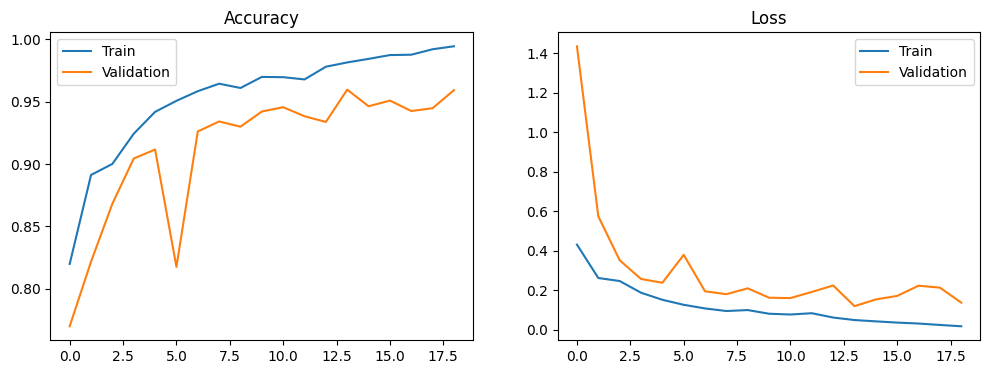

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on test set (unseen during training)
test_results = best_model.evaluate(test_images, test_labels, verbose=0)
print(f"""
Test Accuracy: {test_results[1]:.4f}
Test Precision: {test_results[2]:.4f}
Test Recall: {test_results[3]:.4f}
Test Loss: {test_results[0]:.4f}
""")


Test Accuracy: 0.9596
Test Precision: 0.9384
Test Recall: 0.8825
Test Loss: 0.1200



82/82 ━━━━━━━━━━━━━━━━━━━━ 30s 346ms/step


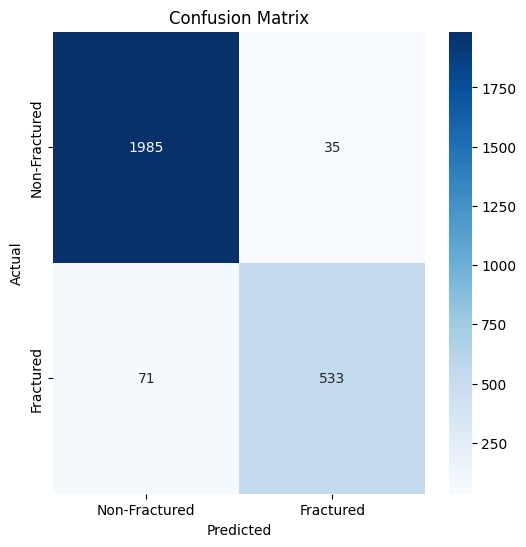

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (best_model.predict(test_images) > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fractured', 'Fractured'],
            yticklabels=['Non-Fractured', 'Fractured'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred,
                          target_names=['Non-Fractured', 'Fractured']))

               precision    recall  f1-score   support

Non-Fractured       0.97      0.98      0.97      2020
    Fractured       0.94      0.88      0.91       604

     accuracy                           0.96      2624
    macro avg       0.95      0.93      0.94      2624
 weighted avg       0.96      0.96      0.96      2624



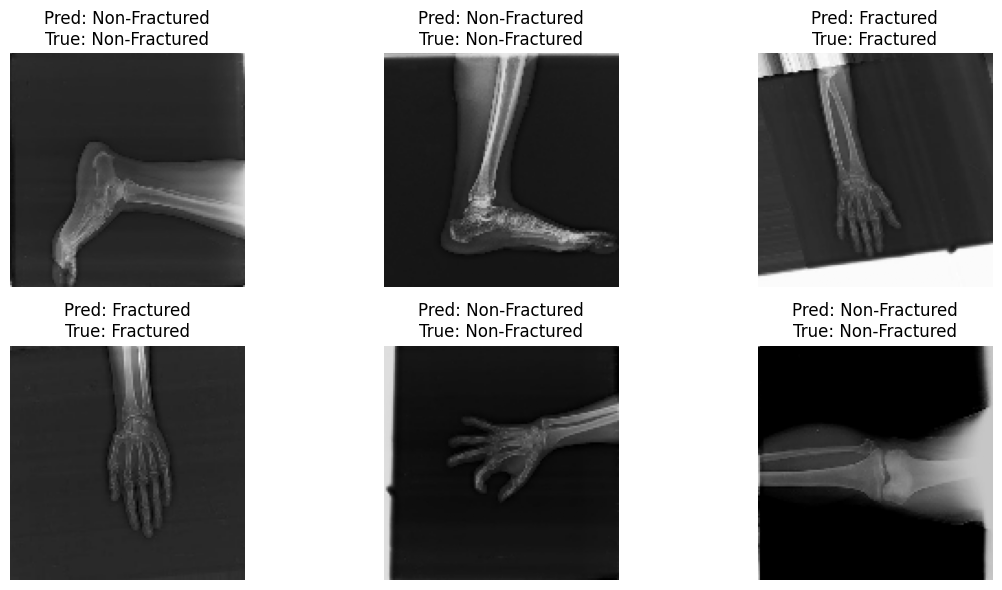

In [ ]:
import random

# Visualize random test samples with predictions
plt.figure(figsize=(12,6))
for i in range(6):
    idx = random.randint(0, len(test_images)-1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_images[idx])
    pred = "Fractured" if y_pred[idx] else "Non-Fractured"
    true = "Fractured" if test_labels[idx] else "Non-Fractured"
    plt.title(f"Pred: {pred}\nTrue: {true}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Save final model (recommended format)
best_model.save('final_fracture_model.keras')

# Optional: Convert to TensorFlow Lite for mobile
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with open('fracture_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp0p67ux2w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134699774306704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774307472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774304976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774308432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774306128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774312080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774305360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703915761744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774307088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134701849065616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134699774306896